In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm
from sklearn.datasets import load_boston
import matplotlib.font_manager as fm
import scipy as sp



# # GPU 설정 : 런타임 > 런타임 유형 변경 > GPU
# # GPU 사용 가능한지 확인
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

# 자기 상관 계수
선형 회귀 모형에서는 오차(disturbance)들이 서로 (모수-조건부) 독립이라고 가정하고 있다. 따라서 잔차(residual)도 서로 독립이어야 한다. 만약 서로 독립이 아니라면 선형회귀 모형이 아닌 ARMA 모형 등의 시계열 모형을 사용해야 한다.

오차가 독립인지 검정하는 방법은 잔차를 시계열로 가정하여 자기상관계수를 구하는 것이다. 만약 독립이라면 시차(lag)가 0인 경우를 제외하고는 자기상관계수 ρl 이 0이어야 한다. 이를 검사하는 검증으로는 다음과 같은 것들이 있다.

Box-Pierce 검정

Ljung-Box 검정

Durbin-Watson 검정

이 검정들은 다음과 같은 귀무 가설을 검증한다.

H0:ρl=0 for i=1,2,⋯,l
여기에서는 회귀분석의 성능을 향상시키거나 모형이 가지는 제한조건 등을 충족시키기 위해 모형을 비선형으로 변형(transform)하는 방법에 대해 알아본다.



## 비선형 변형
만약 독립변수와 종속변수간의 관계가 비선형이면 이 관계를 선형으로 바꿀 수 있도록 독립변수를 비선형 변환할 수 있다. 예를 들어 보스턴 집값 데이터에서 집값과 LSTAT 데이터는 다음 그림에서 보듯이 비선형 관계를 가진다.

In [ ]:
bst=load_boston()
bst_x=pd.DataFrame(bst.data,columns=bst.feature_names)
bst_y=pd.DataFrame(bst.target,columns=["MEDV"])
bst_all=pd.merge(bst_x,bst_y,left_index=True,right_index=True)

sns.scatterplot(x="LSTAT",y="MEDV",data=bst_all)
plt.show()

In [ ]:
# 단순히 LSTAT과 종속변수간의 선형모형을 구한 결과는 다음과 같다."""
model1 = sm.OLS.from_formula("MEDV ~ LSTAT", data=bst_all)
result1 = model1.fit()
print(result1.summary())



*** 더빈왓슨 테스트 ***

Durbin-Watson test는 선형모델의 잔차가 자기상관관계가 있는지 여부를 확인합니다.

    - 귀무가설(H0)는 잔차들 사이에 자기상관관계가 없다, 즉 독립적이다.
    
    - 대립가설(Ha)는 잔차가 자기상관관계가 있다.


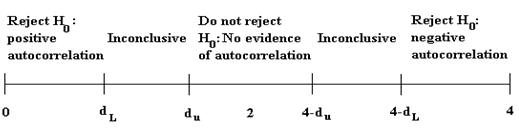



*** 하르케-베라 테스트 ***

정규성을 검정하기 위해 사용하는 테스트로써, 보통은 정규성이 있음을 보이기 위해서 사용한다.

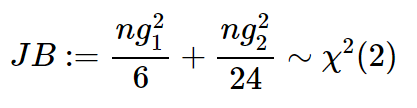

샤피로-윌크 테스트(정규성을 검정하기 위해 사용하는 테스트로써, 보통은 정규성이 있음을 보이기 위해서 사용한다.)와 다른 점은 왜도와 첨도를 이용해서 검정을 한다는 것밖에 없다. 정규분포는 모왜도와 모첨도가 모두 
0이며, 표본왜도 g1 와 표본첨도 g2 에 대해 검정통계량 JB 는 다음과 같이 구해지고 자유도 2 의 카이제곱분포를 따른다.

In [ ]:
# 다음 그림은 예측값과 실제 데이터를 비교한 것이다. 
# 선형모형이 적합하지 않음을 알 수 있다.

y_hat1=result1.predict(bst_all)
df1=pd.concat([y_hat1,bst_all.LSTAT],axis=1).sort_values("LSTAT")
df1.columns=["Predict","LSTAT"]
df1.plot(x="LSTAT",style="r-",lw=3)
plt.plot(bst_all.LSTAT,bst_all.MEDV,"bo",alpha=0.5)

plt.show()

In [ ]:
# LSTAT값을 제곱한 비선형 독립변수를 추가 >> 결과가 향상
model2=sm.OLS.from_formula("MEDV ~ LSTAT +I(LSTAT**2)",data=bst_all)
result2=model2.fit()
print(result2.summary())

In [ ]:
y_hat2=result2.predict(bst_all)
df2=pd.concat([y_hat2,bst_all.LSTAT],axis=1).sort_values("LSTAT")
df2.columns=["Predict","LSTAT"]
df2.plot(x="LSTAT",style="r-",lw=3)
plt.plot(bst_all.LSTAT,bst_all.MEDV,"bo",alpha=0.5)

plt.show()

## 범주형을 사용한 비선형성
독립변수의 비선형성을 포착하는 또 다른 방법 중 하나는 강제로 범주형 값으로 만드는 것이다. 범주형 값이 되면서 독립변수의 오차가 생기지만 이로 인한 오차보다 비선형성으로 얻을 수 있는 이익이 클 수도 있다.

보스턴 집값 데이터에서 종속변수와 RM 변수의 관계는 선형에 가깝지만 방의 갯수가 아주 작아지거나 아주 커지면 선형모형에서 벗어난다.

In [ ]:
sns.scatterplot(x="RM", y="MEDV", data=bst_all)
plt.show()

In [ ]:
model3=sm.OLS.from_formula("MEDV ~ RM",data=bst_all)
result3=model3.fit()
print(result3.summary())

In [ ]:
''' 
RM 변수값을 강제로 정수로 라운딩(rounding)하면 RM 변수가 가지는 비선형성을 잡을 수 있다. 
다음 플롯은 카테고리값으로 변한 RM 변수와 종속변수의 관계를 시각화한 것이다.
'''
rooms=np.arange(3,10)
labels=[str(r) for r in rooms[:1]]
bst_all["CAT_RM"]=np.round(bst_all.RM)

sns.barplot(x="CAT_RM",y="MEDV",data=bst_all)
plt.show()

In [ ]:
'''
이렇게 하면 RM 변수으로 인한 종속변수의 변화를 비선형 상수항으로 모형화 할 수 있다. 
선형모형보다 성능이 향상된 것을 볼 수 있다.
'''
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))", data=bst_all)
result4 = model4.fit()
print(result4.summary())

In [ ]:
sns.scatterplot(x="CAT_RM", y="MEDV", data=bst_all)
plt.show()

## 종속변수 변형
 경우에 따라서는 종속변수를 변형할 수도 있다. 예를 들어 LSTAT 독립변수로 보스턴 집값을 예측하는 선형회귀모형의 예측값과 실제값을 그리면 다음과 같다.

In [ ]:
plt.scatter(bst.target,y_hat1)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()
'''
모형이 올바르다면 예측치와 실제 종속변수값을 그린 스캐터 플롯은 선형적인 모습이 나와야 한다. 
하지만 실제로는 제곱근이나 로그 그래프와 더 유사하다. 
이러한 경우에는 이 스캐터 플롯을 선형적으로 만들어 주도록 예측치를 비선형 변환한다. 
여러가지 모형을 비교해보면 독립변수와 종속변수를 모두 로그 변환한 모형이 가장 좋다는 것을 알 수 있다.
'''

In [ ]:
model11=sm.OLS.from_formula("np.sqrt(MEDV)~LSTAT",data=bst_all)
result11=model11.fit()
print(result11.summary())

In [ ]:
plt.subplot(121)
plt.scatter(bst.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(bst.target, (result11.predict(bst_all))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [ ]:
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT", data=bst_all)
result12 = model12.fit()
print(result12.summary())

In [ ]:
plt.subplot(121)
plt.scatter(bst.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(bst.target, np.exp(result12.predict(bst_all)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()

In [ ]:
model13 = sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=bst_all)
result13 = model13.fit()
print(result13.summary())


In [ ]:
plt.subplot(121)
plt.scatter(bst.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(bst.target, np.exp(result13.predict(bst_all)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()

## 시간 독립변수의 변형
독립변수가 시간인 경우에는 특정 시점에서 경과된 시간값으로 변형해야 한다. 

In [ ]:
# 일일 전기사용량 데이터에 시간 열 삽입
import datetime as dt

elec=sm.datasets.get_rdataset("elecdaily",package="fpp2")
elec_df=elec.data
elec_df["Date"]=pd.date_range("2014-1-1","2014-12-31")
elec_df["Ordinal"]=elec_df.Date.map(dt.datetime.toordinal)
elec_df["Timestemp"]=elec_df.Date.map(dt.datetime.timestamp)
elec_df["Year"] = elec_df.Date.dt.year
elec_df["Month"] = elec_df.Date.dt.month
elec_df["DayOfYear"] = elec_df.Date.dt.dayofyear
elec_df["DayOfMonth"] = elec_df.Date.dt.daysinmonth
elec_df["DayOfWeek"] = elec_df.Date.dt.dayofweek
elec_df["WeekOfYear"] = elec_df.Date.dt.weekofyear
elec_df["Weekday"] = elec_df.Date.dt.weekday
elec_df["IsMonthStart"] = elec_df.Date.dt.is_month_start
elec_df["IsMonthEnd"] = elec_df.Date.dt.is_month_end
elec_df.tail()

In [ ]:
featur_nm=elec_df.columns.to_list()
featur_nm.remove("Demand")
featur_nm.remove("Date")
formula='''
Demand ~ scale(Ordinal) + C(Month)+DayOfYear+C(DayOfMonth)+C(DayOfWeek)+C(Weekday)+C(IsMonthStart) + C(IsMonthEnd)'''
model_time=sm.OLS.from_formula(formula,data=elec_df)
result_time=model_time.fit()
print(result_time.summary())

## 주기성을 가지는 독립변수
독립변수가 주기성을 가지는 경우에는 그대로 사용하면 모형이 주기성을 가지지 못한다. 예를 들어 scikit-learn의 covtype 데이터를 살펴보자. 이 데이터는 원래 특징값들로부터 특정 범주값을 예측하는 분류 문제용 데이터 집합이지만 Aspect라는 변수를 독립변수로 하고 Hillshade_9am라는 변수를 종속변수로 하는 회귀분석 문제로 가정한다.

In [ ]:
# from sklearn.datasets import fetch_covtype
'''
Aspect 변수는 도(degree) 단위의 각도를 나타내는 독립변수이므로 0부터 360까지의 값을 가진다. 
Aspect가 0인 경우와 360인 경우는 독립변수가 실질적으로 같기 때문에 같은 종속변수값을 예측해야 한다.
'''
covtype=fetch_covtype()
covtype
featur_nm=["Aspect","Hillshade_9am"]
df_covtype=pd.DataFrame(covtype.data[:,[1,6]],columns=featur_nm)
df_covtype=df_covtype.sample(10000,random_state=0)
df_covtype.head()

In [ ]:
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.show()

In [ ]:
'''하지만 Aspect를 일반 실수형 독립변수처럼 사용하면 Aspect가 0도일 때와 360도일 때 다른 종속변수값이 예측된다.'''
model_time1=sm.OLS.from_formula(
    "Hillshade_9am ~ Aspect+I(Aspect**2)+I(Aspect**3)"
    ,data=df_covtype)
result_time1=model_time1.fit()
print(result_time1.summary())

In [ ]:
test_time1=pd.DataFrame([[0],[360]],columns=["Aspect"])
predict_time1=result_time1.predict(test_time1)
predict_time1
# 0일 때와 360일 때,다르게 예측함

In [ ]:
y_hat_time1=result_time1.predict(df_covtype)
covtype_time1=pd.concat([y_hat_time1,df_covtype.Aspect],axis=1).sort_values("Aspect")
covtype_time1.columns=["Predict","Aspect"]
covtype_time1.plot(x="Aspect",style="r-",lw=3)
sns.scatterplot(x="Aspect",y="Hillshade_9am",data=df_covtype)
plt.hlines(predict_time1[0],0,360)
plt.hlines(predict_time1[1],0,360)
plt.show()
# 예측값이 다름

이를 방지하기 위해 일반적으로 주기성을 띄는 독립변수는 다음처럼 두 개의 독립변수로 분리한다.

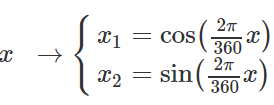


In [ ]:
f=2*np.pi/360

model_time2=sm.OLS.from_formula(
'Hillshade_9am ~ np.cos(f*Aspect) +np.sin(f*Aspect)',
data=df_covtype
)

result_time2=model_time2.fit()
print(result_time2.summary())

In [ ]:
# 이렇게 하면 독립변수의 특징을 유지하면서 모형이 주기성을 가지게 된다.
predict_time2=result_time2.predict(test_time1)
predict_time2

In [ ]:
y_hat_time2=result_time2.predict(df_covtype)
covtype_time2=pd.concat([y_hat_time2,df_covtype.Aspect],axis=1).sort_values("Aspect")
covtype_time2.columns=["Predict","Aspect"]
covtype_time2.plot(x="Aspect",style="r-",lw=3)
sns.scatterplot(x="Aspect",y="Hillshade_9am",data=df_covtype)
plt.hlines(predict_time2[0],0,360)
plt.hlines(predict_time2[1],0,360)
plt.show()
# 예측값이 동일함